In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

# add the src directory to the path
import sys
sys.path.append('../src')

from data_loader import load_data
from config import settings

df = load_data(settings.FILE_NAME)

# to do zero shot or not to do zero shot
DO_ZERO_SHOT = False

# columns to use for classification
taxonomy_info = ["Description", "Industry", "Category Groups", "Tags"]

In [2]:
df[taxonomy_info].describe()

,Description,Industry,Category Groups,Tags
count,5000,4999,4775,3292
unique,4994,183,2060,3051
top,Airbase serves as an all-in-one platform for s...,Software Development,Health Care,saas
freq,2,764,116,178


## Exploration

### Industry column

In [ ]:
# look at industry - have we got labelled data?
industry_counts = df["Industry"].value_counts().to_frame().reset_index()
industry_counts.columns = ["Industry", "Count"]

# keywords for labelled data
keywords = ['finance', 'financial', 'health']

# find where keywords appear in Industry column (lower case)
mesh = industry_counts["Industry"].str.lower().str.contains('|'.join(keywords))
industry_counts[mesh]

,Industry,Count
3,Financial Services,402
11,Hospitals and Health Care,86
28,Mental Health Care,34
159,Health and Human Services,1
167,Retail Health and Personal Care Products,1
175,Public Health,1


Have existing industry labels for finance and health, although these industries are a sub-category of the new taxonomy of interest. 

- `Financial Services` is a sub-industry of **Finance**
- `Hospitals and Health Care`, `Mental Health Care` etc. are sub-industries of **Health**


### Category Groups column

In [ ]:
# look at category groups - have we got labelled data?
category_counts = df["Category Groups"].value_counts().to_frame().reset_index()
category_counts.columns = ["Category", "Count"]

# keywords for labelled data
keywords = ['finance', 'financial', 'health']

# find where keywords appear in Industry column (lower case)
mesh = category_counts["Category"].str.lower().str.contains('|'.join(keywords))
category_counts[mesh]

,Category,Count
0,Health Care,116
1,Financial Services,99
2,"Financial Services, Lending and Investments",76
8,"Financial Services, Payments, Software",35
10,"Financial Services, Other, Payments, Software",33
...,...,...
2036,"Clothing and Apparel, Commerce and Shopping, D...",1
2045,"Commerce and Shopping, Financial Services, Inf...",1
2047,"Biotechnology, Health Care",1
2049,"Financial Services, Information Technology, Ot...",1


In [ ]:
# keywords for labelled data
keywords = ['financial', 'health']

# find where keywords appear in Industry column (lower case)
mesh = (category_counts["Category"].str.lower().str.contains('financial')) & (category_counts["Category"].str.lower().str.contains('health'))

print(f"We have: {len(category_counts[mesh])} examples of financial & health in the 'Category Groups' column")

category_counts[mesh]


We have: 18 examples of financial & health in the 'Category Groups' column


,Category,Count
75,"Financial Services, Health Care",8
203,"Administrative Services, Financial Services, H...",4
572,"Financial Services, Health Care, Software",2
603,"Financial Services, Health Care, Sports",1
801,"Financial Services, Health Care, Lending and I...",1
837,"Financial Services, Health Care, Internet Serv...",1
859,"Financial Services, Health Care, Professional ...",1
1064,"Financial Services, Health Care, Sales and Mar...",1
1139,"Administrative Services, Financial Services, H...",1
1295,"Administrative Services, Financial Services, H...",1


### Tags column

In [ ]:
# split tags by comma
tags = df["Tags"].str.split(",", expand=True).stack().reset_index(level=1, drop=True).to_frame("Tags")
# find keyword matches
mapping = {}
for keyword in keywords:
    spector_ids = tags[tags["Tags"].str.lower().str.contains(keyword)].index.unique()
    mapping[keyword] = spector_ids

# find the number of tags for each keyword
for keyword in keywords:
    print(f"{keyword}: {len(mapping[keyword])}")

# example
df.loc[mapping["finance"]][taxonomy_info].head()

finance: 110
financial: 107
health: 178


,Description,Industry,Category Groups,Tags
Specter - ID,,,,
5e3a8f19040ca7b0c6f02e40,5Paisa know that your money is precious and ha...,Financial Services,"Financial Services, Privacy and Security","investing, insurance, mutual fund, discount br..."
60422d084ddab8d8bf2ad251,ADAN is a professional body for digital assets...,Civic and Social Organizations,NaN,"blockchain, cryptocurrencies, actifs numérique..."
60226d1d4ddab8d8bf9a632c,AgriBazaar is a one-stop agritech platform tha...,Internet Publishing,"Agriculture and Farming, Apps, Commerce and Sh...","agriculutre, online marketplace, auctions, mar..."
5e3a8f49040ca7b0c6f12efe,AIIB is a multilateral development bank that a...,International Trade and Development,"Financial Services, Lending and Investments","infrastructure, sustainable infrastructure, cr..."
605884964ddab8d8bf804f4c,Airrange makes Excel easy. Turn your Excel 365...,IT Services and IT Consulting,Software,"microsoft 365, excel, data management, collabo..."


## Zero-shot inference

As we have limited data, we can use a zero-shot approach to classify companies into the 3 classes. We can use the [Zero-Shot approach](https://huggingface.co/spaces/joeddav/zero-shot-demo) to do this.

### Run locally

In [3]:
from transformers import pipeline

candidate_labels = ['finance', 'health', 'finance and health']

if DO_ZERO_SHOT:
    # load the model
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

    # test 5
    sequence_to_classify = df['Description'].sample(2).tolist()
    
    zs_output = classifier(sequence_to_classify, candidate_labels, multi_label=True)

    print(zs_output[0])


/opt/homebrew/Caskroom/miniforge/base/envs/specter/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Concat taxonomy columns

In [4]:
# set the max description length to 300 words
max_size = 300
df['description_limited'] = df['Description'].str.split(n=max_size).str[:max_size].str.join(' ')

# NOTE: limiting the description to max_size words due to RAM limitations when running the zero-shot classification

# concat taxonomy columns
taxonomy_info_adj = ["Industry", "Category Groups", "Tags", "description_limited"]

# concat if not null
df['taxonomy_concat'] = df[taxonomy_info_adj].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
df['taxonomy_concat'].str.len().sort_values()

Specter - ID
60f052977d096fb914ba2e42      45
5f5f051da2734681ceb1ce0c      47
6041f7984ddab8d8bf185d44      48
5f35f6ca71eeac40b62e7673      50
63159c8fbfda6f2c1a927a90      51
                            ... 
5e3a8f19040ca7b0c6f04134    2473
61ad0113d0efcf20c6e0337e    2555
5e3a8f1b040ca7b0c6f067ec    2651
5fc7432bbf7e53924df00e71    2718
62ea324a542c2517a479ec31    2749
Name: taxonomy_concat, Length: 5001, dtype: int64

### Run in Sagemaker

For 5000 companies, will take about 10+ hours to run zero-shot.

Can use `HuggingFaceModel` from Sagemaker to run this much quicker on a GPU instance. Requires a default AWS account to be active - check `cat ~/.aws/credentials`

Also requires a Sagemaker role which we will set as an env variable in a .env file at the root of the notebooks directory.

*NOTE: This takes 10mins to run on a p3.8xlarge instance.*

In [5]:
# load env variables from .env file
from dotenv import load_dotenv
from zeroshot import zero_shot_classification_huggingface
import os
import pickle

load_dotenv('.env', verbose=True, override=True)
SAGEMAKER_ROLE = os.getenv("SAGEMAKER_ROLE")

 # NOTE: this takes 10mins to run and spins up a p3 instance ~ 20$ per hour

# full list
sequence_to_classify = df['taxonomy_concat'].tolist()

if DO_ZERO_SHOT:
    # run zero-shot in sagemaker
    zs_output = zero_shot_classification_huggingface(
        sequence_to_classify=sequence_to_classify,
        candidate_labels=candidate_labels,
        instance_type="ml.p3.8xlarge",
        role=SAGEMAKER_ROLE,
    )
    # save the output
    with open(f"output/zs_output_{max_size}.pkl", 'wb') as f:
        pickle.dump(zs_output, f)

## Analysis of results

Things to look at:
- Distributions of probabilities
- Can we apply a threshold to form a decision boundary?
- What is the distribution of scores among industries with 'health' and 'financial' in the industry?
- Of the 29 companies with both 'health' and 'financial' in the category groups, what did the model predict?
- Does this inform a decision boundary?

`len(zs_output) != len(sequence_to_classify)`

zs_output is one less than sequence_to_classify - I can see a bug in `zero_shot_classification_huggingface` which could be causing us to skip the last company as such, we will only join with the top 5000

In [6]:
# load the output
with open(f"output/zs_output_{max_size}.pkl", 'rb') as f:
    zs_output = pickle.load(f)


#### Join

In [7]:
# drop the last company off the df - due to bug mentioned above
# TODO: fix the bug and repeat zero-shot classification
df_results = df.copy()[:-1]
len(df_results)

# get results into the df
_results = pd.DataFrame(
    data=[result['scores'] for result in zs_output],
    columns=[f"{label}_probability" for label in candidate_labels],
    index=df_results.index
)

# concat the results - ignore the index
df_results = pd.concat([df_results, _results], axis=1)
assert len(df_results) == len(_results)

#### Distributions of probabilities

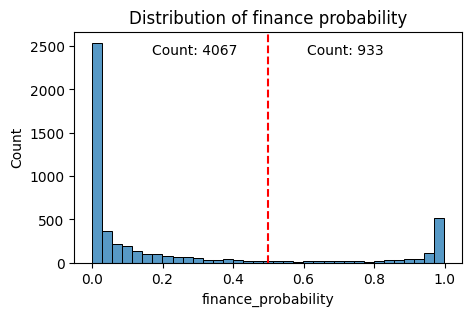

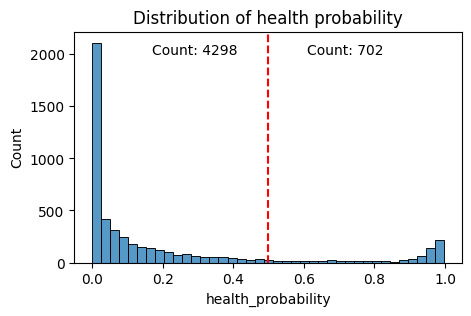

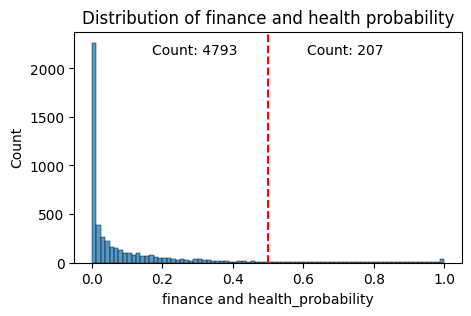

In [8]:
# distributions of each candidate label
for label in candidate_labels:
    plt.figure(figsize=(5, 3))
    plt.title(f"Distribution of {label} probability")
    sns.histplot(df_results[f"{label}_probability"])
    plt.axvline(0.5, color='r', linestyle='--')
    # count those to the right of 0.5
    count_right = len(df_results[df_results[f"{label}_probability"] >= 0.5])
    count_left = len(df_results[df_results[f"{label}_probability"] < 0.5])
    plt.text(0.6, 0.9, f"Count: {count_right}", transform=plt.gca().transAxes)
    plt.text(0.2, 0.9, f"Count: {count_left}", transform=plt.gca().transAxes)
    plt.show()

*These U-shaped distributions look very good for the classification task in hand. There is a clear majority near zero that shouldn't be classed as such and a small peak towards one that should. Where we drawl the decision boundary is down to the use-case in question*

#### Analysis of probabilities
**Can we apply a threshold to form a decision boundary?**

**What is the distribution of scores among industries with 'health' and 'financial' in the industry?**

**Of the 29 companies with both 'health' and 'financial' in the category groups, what did the model predict?**


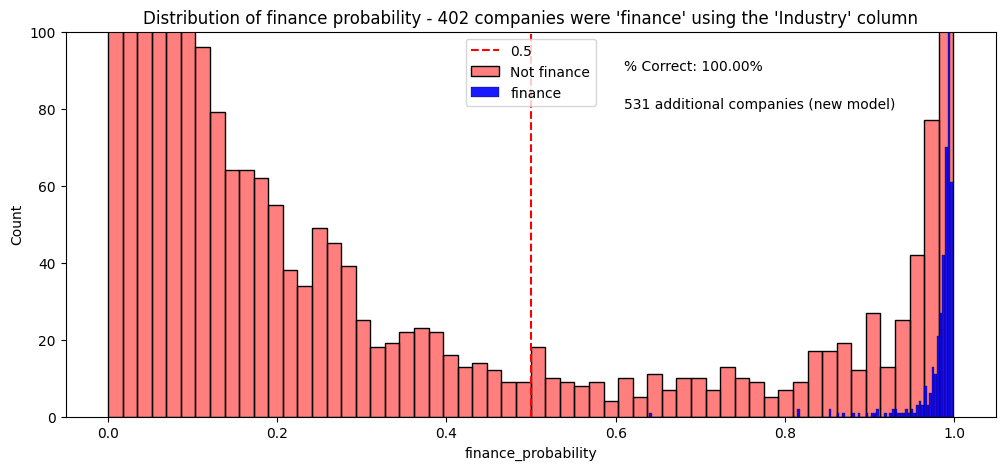

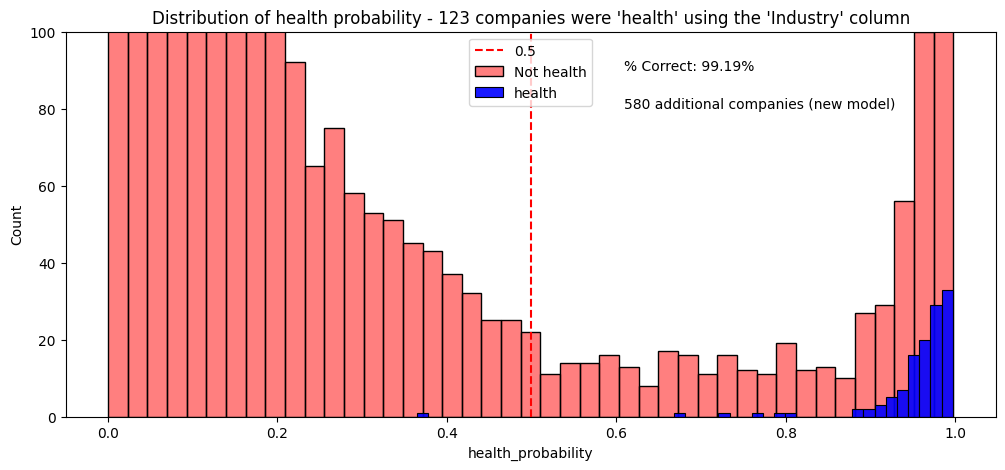

In [9]:
industry_labels = {
    "finance": ["Financial Services"],
    "health": [
        "Hospitals and Health Care", "Mental Health Care", "Health and Human Services",
        "Retail Health and Personal Care Products", "Public Health"
    ]
}

for label in ["finance", "health"]:
    mesh = df_results["Industry"].isin(industry_labels[label])

    plt.figure(figsize=(12, 5))
    sns.histplot(df_results[~mesh][f"{label}_probability"], color='r', alpha=0.5)
    sns.histplot(df_results[mesh][f"{label}_probability"], color='b', alpha=0.9)
    # limit y axis
    plt.ylim(0, 100)
    plt.axvline(0.5, color='r', linestyle='--')
    plt.title(f"Distribution of {label} probability - {len(df_results[mesh])} companies were '{label}' using the 'Industry' column")
    # legend
    plt.legend(['0.5', f'Not {label}', f'{label}'])

    # % correct
    count_right = len(df_results[(df_results[f"{label}_probability"] >= 0.5) & mesh])
    total_in_industry = len(df_results[mesh])
    plt.text(0.6, 0.9, f"% Correct: {count_right / total_in_industry * 100:.2f}%", transform=plt.gca().transAxes)

    # additional classified as label
    count_right = len(df_results[(df_results[f"{label}_probability"] >= 0.5) & ~mesh])
    total_not_in_industry = len(df_results[~mesh])
    plt.text(0.6, 0.8, f"{count_right} additional companies (new model)", transform=plt.gca().transAxes)
    plt.show()

In [10]:
# incorrectly classified as health
incorrect = df_results[(df_results[f"{label}_probability"] < 0.5) & mesh]
# show description
taxonomy_concat = incorrect['taxonomy_concat'].tolist()[0]
print("This company was the only not identified as being related to health, it scored 0.36 (below the 0.5 threshold)")
print(f"Info used in model:\n\n{taxonomy_concat}")

This company was the only not identified as being related to health, it scored 0.36 (below the 0.5 threshold)
Info used in model:

Hospitals and Health Care Health Care Ark Behavioral Health is a network of Drug and Alcohol Addiction Treatment Facilities that provide a variety of levels of care to those who are prepared to begin their journey toward recovery.


*NOTE:* Manually checking the above in the huggingface model API [here](https://huggingface.co/facebook/bart-large-mnli?candidateLabels=health%2C+finance%2C+finance+and+health&multiClass=true&text=Hospitals+and+Health+Care+Health+Care+Ark+Behavioral+Health+is+a+network+of+Drug+and+Alcohol+Addiction+Treatment+Facilities+that+provide+a+variety+of+levels+of+care+to+those+who+are+prepared+to+begin+their+journey+toward+recovery.) shows that this prediction was not an error.

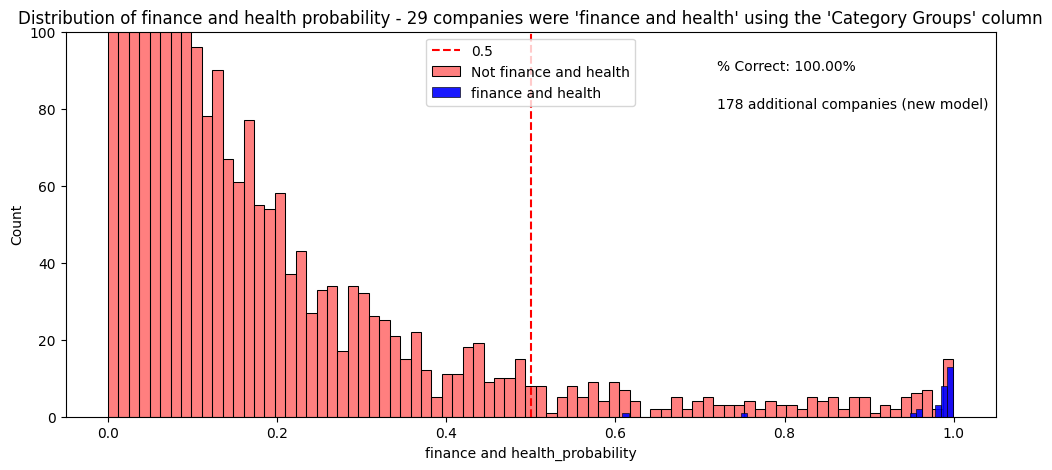

In [11]:
# check finance and health - have 29 companies from Category Groups
mesh = (df_results["Category Groups"].str.lower().str.contains('financial')) & (df_results["Category Groups"].str.lower().str.contains('health'))
label = "finance and health"

plt.figure(figsize=(12, 5))
sns.histplot(df_results[~mesh][f"{label}_probability"], color='r', alpha=0.5)
sns.histplot(df_results[mesh][f"{label}_probability"], color='b', alpha=0.9)
# limit y axis
plt.ylim(0, 100)
plt.axvline(0.5, color='r', linestyle='--')
plt.title(f"Distribution of {label} probability - {len(df_results[mesh])} companies were '{label}' using the 'Category Groups' column")
# legend with location
plt.legend(['0.5', f'Not {label}', f'{label}', ], loc='upper center')

# % correct
count_right = len(df_results[(df_results[f"{label}_probability"] >= 0.5) & mesh])
total_in_industry = len(df_results[mesh])
plt.text(0.7, 0.9, f"% Correct: {count_right / total_in_industry * 100:.2f}%", transform=plt.gca().transAxes)

# additional classified as label
count_right = len(df_results[(df_results[f"{label}_probability"] >= 0.5) & ~mesh])
total_not_in_industry = len(df_results[~mesh])
plt.text(0.7, 0.8, f"{count_right} additional companies (new model)", transform=plt.gca().transAxes)

plt.show()

## Populate new industry classification column

A decision will need to be made when more than one label probability is above the decision boundary. For now, we will do the following:
- If 'finance and health' is above the decision boundary, assign this label (as this is a subset of the other two labels)
- If 'finance' and 'health' are both above the decision boundary, assign the higher probability label
- If only one label is above the decision boundary, assign this label
- If neither label is above the decision boundary, assign 'other'

In [22]:
decision_boundary = 0.5

def assign_logic(row):
    if row['finance and health_probability'] >= decision_boundary:
        return "finance and health"
    elif row['finance_probability'] >= decision_boundary and row['finance_probability'] > row['health_probability']:
        return "finance"
    elif row['health_probability'] >= decision_boundary and row['health_probability'] > row['finance_probability']:
        return "health"
    else:
        return "other"


# assign the label to 'New Industry' column
df_results["New Industry"] = df_results.apply(assign_logic, axis=1)

df_results.to_csv("output/taxonomy_result.csv")